In [1]:
import matplotlib.pyplot as plt
from typing import List, Tuple, Union
import math
import os

import torch
import plotly.express as px

from rnn import RNN
from utils import plot_features_in_2d, plot_features_in_Nd, plot_features_in_Nd_discrete

torch.manual_seed(8)

## Superposition with mse loss and Vanilla RNN

### Setup

In [2]:
from train import CopySuperPosConfig, train_model, cosine_decay_lr, constant_lr, linear_lr, evaluate_model
from data import generate_sparse_copyset
def plot_loss(losses):
    return plt.plot(losses)

def train_setup(cfg, feature_probabilities, importances=1,
                 epochs=10000, lr=0.01, lr_schedule=constant_lr,
                 w_decay=0,
                 dir_name="superpos_mse_models"):
    models, losses = train_model(
            cfg, 
            feature_probabilities.tolist(), 
            num_epochs=epochs, 
            lr=lr, 
            lr_schedule=lr_schedule,
            w_decay=w_decay,
            importances=importances
        )
    #checkpoint all models
    os.makedirs(dir_name, exist_ok=True)
    for i, model in enumerate(models):
        torch.save(model.state_dict(), f"{dir_name}/model_{i}.ckpt")
    return models, losses

def load_weights(cfg, dir_name):
    files = os.listdir(dir_name)
    files = sorted(files, key=lambda x: int(x[:-5].split("_")[-1]))
    modelweights = [torch.load(f"{dir_name}/{f}") for f in files]
    models = [RNN(cfg.n_features+1, cfg.d_hidden, cfg.n_features) for _ in range(cfg.n_inst)]
    _ = [m.load_state_dict(sd) for m, sd in zip(models, modelweights)]
    return models


### Uniform Importances

In [10]:
cfg = CopySuperPosConfig(n_inst=8, n_features=4, gru=False,
                         d_hidden=2, copy_length=2, batch_size=32)
cfg_copy = CopySuperPosConfig(n_inst=8, n_features=4, gru=False,
                         d_hidden=2, copy_length=2, batch_size=32)     
end_prob = 0.02
end_prob = 1 - math.pow(1 - end_prob, cfg.copy_length)          
base = 1/end_prob     
feature_probabilities = base ** -torch.linspace(0, 1, cfg.n_inst)
colors = 0.9 ** torch.arange(cfg.n_features+cfg.d_hidden+1)
colors_in = 0.9 ** torch.arange(cfg.n_features+1)

In [65]:
dr = "superpos_uniimport"
models, losses = train_setup(cfg, feature_probabilities, 
                            dir_name="superpos_uniimport_normed", 
                            lr=0.005, lr_schedule=cosine_decay_lr)
# models = load_weights(cfg, dr)

Average Loss: 0.027813: 100%|██████████| 10000/10000 [00:59<00:00, 169.02it/s]


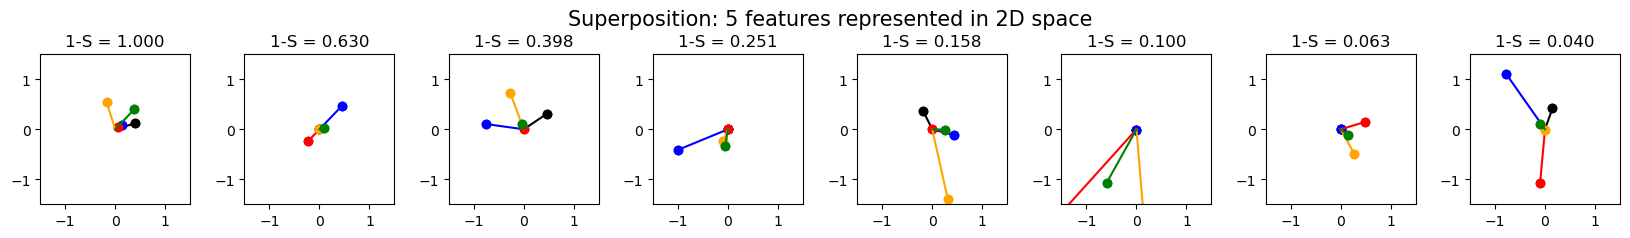

In [66]:
weight_cat = lambda x, y: torch.cat([x, y], dim=1)
cfg_copy.n_features=cfg.n_features + 1
W = torch.stack([model.layers[0].input_to_hidden.weight for model in models])

plot_features_in_2d(W, 
                    colors=["black", "blue", "red", "orange", "green"],
                    title=f"Superposition: {cfg_copy.n_features} features represented in 2D space",
    subplot_titles=[f"1-S = {i:.3f}" for i in feature_probabilities.squeeze()],
)


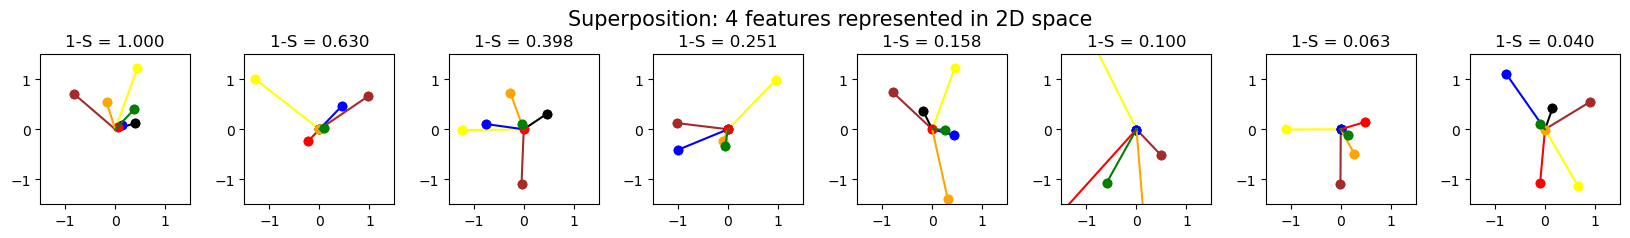

In [67]:
weight_cat = lambda x, y: torch.cat([x, y], dim=1)
cfg_copy.n_features=cfg.n_features + cfg.d_hidden+1
W = torch.stack([weight_cat(model.layers[0].hidden_to_hidden.weight, 
                            model.layers[0].input_to_hidden.weight) for model in models])

plot_features_in_2d(W, 
                    colors=["yellow", "brown", "black", "blue", "red", "orange", "green"],
    title=f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles=[f"1-S = {i:.3f}" for i in feature_probabilities.squeeze()],
)


In [68]:
plot_features_in_Nd(
    W,
    height=800,
    width=1600,
    title="ReLU output model: n_features = 5, d_hidden = 2, I<sub>i</sub> = 1<sup>i</sup>",
    subplot_titles=[f"Feature prob = {i:.3f}" for i in feature_probabilities],
)

In [99]:
model_idx = 7
evaluate_model(models[model_idx], cfg, feature_probabilities[model_idx])

(0.0032220516266534107, 0.0)

lowest losses are experiences w more superposition -- when loss is like 0.006 here, there was basically no superposition in the most sparse case

### Non-Uniform Importances

In [9]:
cfg_imp = CopySuperPosConfig(n_inst=8, n_features=4, gru=False,
                         d_hidden=2, copy_length=2, batch_size=32)
cfg_imp_copy = CopySuperPosConfig(n_inst=8, n_features=4, gru=False,
                         d_hidden=2, copy_length=2, batch_size=32)                         
feature_probabilities = 50 ** -torch.linspace(0, 1, cfg_imp.n_inst)
importances = 0.7 ** torch.arange(cfg_imp.n_features)

In [10]:
# models, losses = train_setup(cfg_imp, feature_probabilities, importances=importances, lr=0.001, lr_schedule=cosine_decay_lr,
#                             dir_name="superpos_import_low")
models = load_weights(cfg_imp, "superpos_import_low")

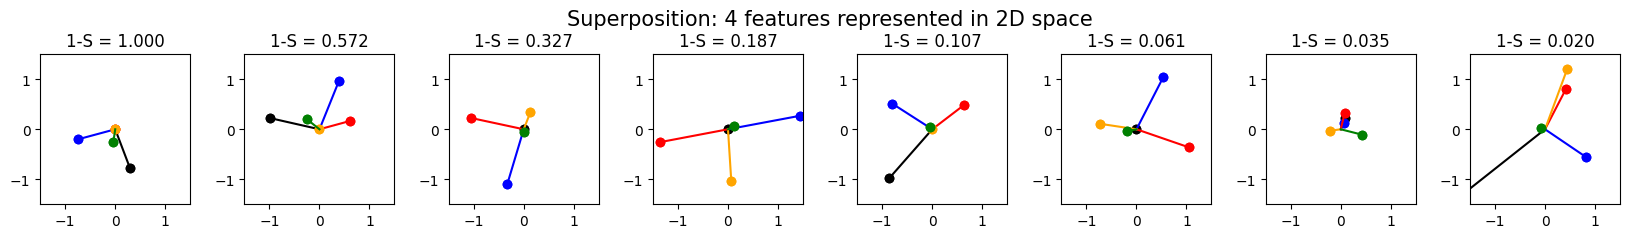

In [11]:
weight_cat = lambda x, y: torch.cat([x, y], dim=1)
cfg_imp_copy.n_features=cfg_imp.n_features + 1
W = torch.stack([model.layers[0].input_to_hidden.weight for model in models])

plot_features_in_2d(W, 
                    colors=["black", "blue", "red", "orange", "green"],
                    title=f"Superposition: {cfg_imp.n_features} features represented in 2D space",
    subplot_titles=[f"1-S = {i:.3f}" for i in feature_probabilities.squeeze()],
)


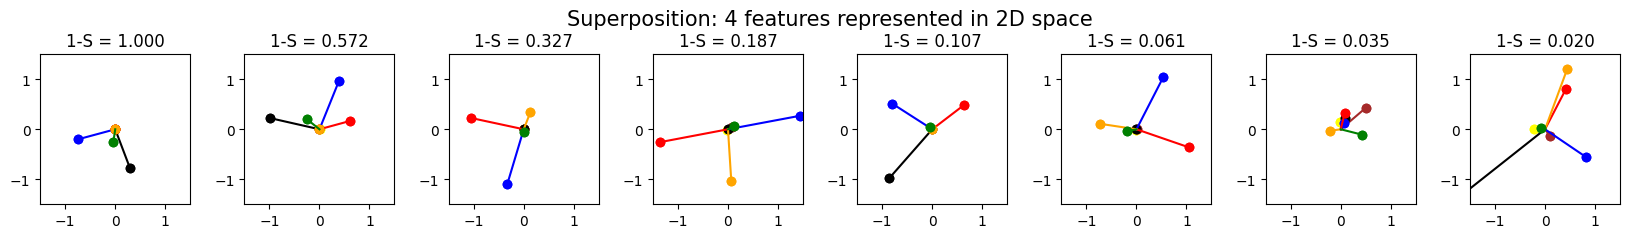

In [15]:
weight_cat = lambda x, y: torch.cat([x, y], dim=1)
cfg_imp_copy.n_features=cfg_imp.n_features + cfg_imp.d_hidden+1
W = torch.stack([weight_cat(model.layers[0].hidden_to_hidden.weight, 
                            model.layers[0].input_to_hidden.weight) for model in models])

plot_features_in_2d(W, 
                    colors=["yellow", "brown", "black", "blue", "red", "orange", "green"],
    title=f"Superposition: {cfg_imp.n_features} features represented in 2D space",
    subplot_titles=[f"1-S = {i:.3f}" for i in feature_probabilities.squeeze()],
)

In [19]:
plot_features_in_Nd(
    W,
    height=800,
    width=1600,
    title="ReLU output model: n_features = 5, d_hidden = 2, I<sub>i</sub> = 1<sup>i</sup>",
    subplot_titles=[f"Feature prob = {i:.3f}" for i in feature_probabilities],
)

In [18]:
model_idx = 7
evaluate_model(models[model_idx], cfg_imp, feature_probabilities[model_idx], importances=importances)

(0.0017004981617086412, 0.1)

### Uniform L2 regularized

Sparsity in the hidden vectors is difficult to control, since the hidden features are a result of g.d. I also see magnitude effects in the plots above: the vectors tend to differ not only in direction, but also in magnitude. Replacing ReLU with tanh in TMS, produces largely orthogonal or parallel vectors that, if parallel, differ in magnitude not direction. 

Let's see if magnitude effects can be done away w -- using L2. Are directions important? Or are they just an artifact of recurrent dynamics?

In [3]:
cfg_decay = CopySuperPosConfig(n_inst=8, n_features=4, gru=False,
                         d_hidden=2, copy_length=2, batch_size=32)
cfg_decay_copy = CopySuperPosConfig(n_inst=8, n_features=4, gru=False,
                         d_hidden=2, copy_length=2, batch_size=32)                         
end_prob = 0.02
end_prob = 1 - math.pow(1 - end_prob, cfg_decay.copy_length)          
base = 1/end_prob     
feature_probabilities = base ** -torch.linspace(0, 1, cfg_decay.n_inst)
colors = 0.9 ** torch.arange(cfg_decay.n_features+cfg_decay.d_hidden+1)
colors_in = 0.9 ** torch.arange(cfg_decay.n_features+1)

In [4]:
dr = "superpos_uniimport_l2"
models, losses = train_setup(cfg_decay, feature_probabilities, 
                            dir_name=dr, 
                            lr=0.001, lr_schedule=cosine_decay_lr, w_decay=1e-4)
# models = load_weights(cfg_decay, dr)

Average Loss: 0.022766: 100%|██████████| 10000/10000 [01:11<00:00, 139.63it/s]


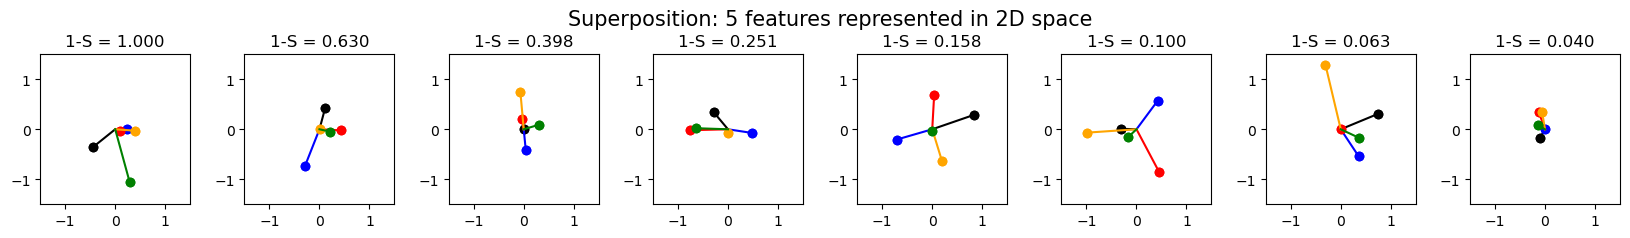

In [5]:
weight_cat = lambda x, y: torch.cat([x, y], dim=1)
cfg_decay_copy.n_features=cfg_decay.n_features + 1
W = torch.stack([model.layers[0].input_to_hidden.weight for model in models])

plot_features_in_2d(W, 
                    colors=["black", "blue", "red", "orange", "green"],
                    title=f"Superposition: {cfg_decay_copy.n_features} features represented in 2D space",
    subplot_titles=[f"1-S = {i:.3f}" for i in feature_probabilities.squeeze()],
)

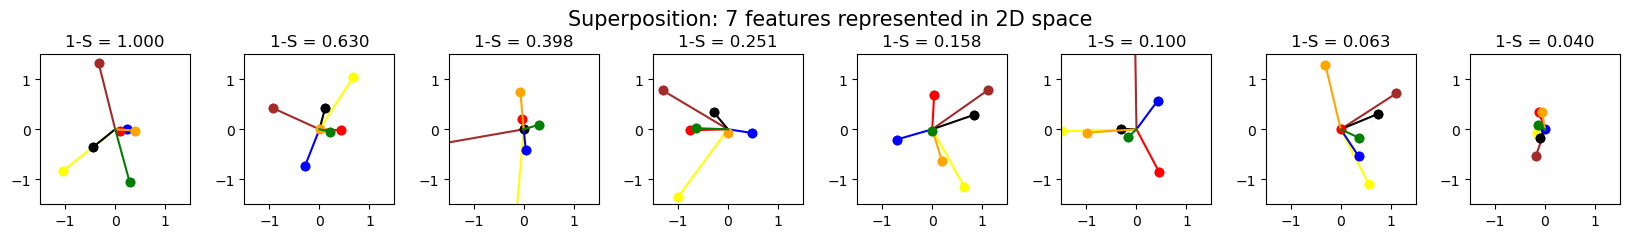

In [6]:
weight_cat = lambda x, y: torch.cat([x, y], dim=1)
cfg_decay_copy.n_features=cfg_decay.n_features + cfg_decay.d_hidden+1
W = torch.stack([weight_cat(model.layers[0].hidden_to_hidden.weight, 
                            model.layers[0].input_to_hidden.weight) for model in models])

plot_features_in_2d(W, 
                    colors=["yellow", "brown", "black", "blue", "red", "orange", "green"],
    title=f"Superposition: {cfg_decay_copy.n_features} features represented in 2D space",
    subplot_titles=[f"1-S = {i:.3f}" for i in feature_probabilities.squeeze()],
)


In [7]:
plot_features_in_Nd(
    W,
    height=800,
    width=1600,
    title="ReLU output model: n_features = 5, d_hidden = 2, I<sub>i</sub> = 1<sup>i</sup>",
    subplot_titles=[f"Feature prob = {i:.3f}" for i in feature_probabilities],
)

In [22]:
model_idx = 6
evaluate_model(models[model_idx], cfg_decay, feature_probabilities[model_idx])

(0.006187737314030528, 0.0)

definitely superposition in the LRH sense is cleaner now, but mags are still around. Why?

### Superpos Large Small Hidden Uniform

In [10]:
cfg_large = CopySuperPosConfig(n_inst=8, n_features=80, gru=False,
                         d_hidden=40, copy_length=5, batch_size=64)
cfg_large_copy = CopySuperPosConfig(n_inst=8, n_features=80, gru=False,
                         d_hidden=40, copy_length=5, batch_size=32)                         
end_prob = 0.02
end_prob = 1 - math.pow(1 - end_prob, cfg_large.copy_length)          
base = 1/end_prob     
feature_probabilities = base ** -torch.linspace(0, 1, cfg_large.n_inst)
colors = 0.9 ** torch.arange(cfg_large.n_features+cfg_large.d_hidden+1)
colors_in = 0.9 ** torch.arange(cfg_large.n_features+1)

In [4]:
dr = "superpos_uniimport_l2_large"
models, losses = train_setup(cfg_large, feature_probabilities, 
                            dir_name=dr, epochs=1000,
                            lr=0.01, lr_schedule=cosine_decay_lr)
# models = load_weights(cfg_large, dr)

Average Loss: 0.030646: 100%|██████████| 1000/1000 [00:20<00:00, 47.96it/s]


In [6]:
weight_cat = lambda x, y: torch.cat([x, y], dim=1)
fold_bias = lambda w, b: w
cfg_large_copy.n_features=cfg_large.n_features + cfg_large.d_hidden+1
W = torch.stack([weight_cat(fold_bias(
                                    model.layers[0].hidden_to_hidden.weight,
                                    model.layers[0].hidden_to_hidden.bias.unsqueeze(-1)),
                            fold_bias(
                                    model.layers[0].input_to_hidden.weight, model.layers[0].input_to_hidden.bias.unsqueeze(-1)
                                    )
                            ) for model in models])
plot_features_in_Nd(
    W,
    height=800,
    width=1600,
    title="ReLU output model: n_features = 80, d_hidden = 121, I<sub>i</sub> = 1<sup>i</sup>",
    subplot_titles=[f"Feature prob = {i:.3f}" for i in feature_probabilities]
)

### Superpos Large Larger hidden

In [3]:
cfg_large_large = CopySuperPosConfig(n_inst=8, n_features=80, gru=False,
                         d_hidden=80, copy_length=5, batch_size=64)
cfg_large_large_copy = CopySuperPosConfig(n_inst=8, n_features=80, gru=False,
                         d_hidden=80, copy_length=5, batch_size=64)                         
end_prob = 0.02
end_prob = 1 - math.pow(1 - end_prob, cfg_large_large.copy_length)          
base = 1/end_prob     
feature_probabilities = base ** -torch.linspace(0, 1, cfg_large_large.n_inst)
colors = 0.9 ** torch.arange(cfg_large_large.n_features+cfg_large_large.d_hidden+1)
colors_in = 0.9 ** torch.arange(cfg_large_large.n_features+1)

In [4]:
dr = "superpos_uniimport_l2_large_large"
models, losses = train_setup(cfg_large_large, feature_probabilities, 
                            dir_name=dr, epochs=1000,
                            lr=0.01, lr_schedule=cosine_decay_lr)
# models = load_weights(cfg_large, dr)

Average Loss: 0.026589: 100%|██████████| 1000/1000 [00:26<00:00, 37.65it/s]


In [6]:
weight_cat = lambda x, y: torch.cat([x, y], dim=1)
fold_bias = lambda w, b: w
cfg_large_large_copy.n_features=cfg_large_large.n_features + cfg_large_large.d_hidden+1
W = torch.stack([weight_cat(fold_bias(
                                    model.layers[0].hidden_to_hidden.weight,
                                    model.layers[0].hidden_to_hidden.bias.unsqueeze(-1)),
                            fold_bias(
                                    model.layers[0].input_to_hidden.weight, model.layers[0].input_to_hidden.bias.unsqueeze(-1)
                                    )
                            ) for model in models])
plot_features_in_Nd(
    W,
    height=800,
    width=1600,
    title="ReLU output model: n_features = 80, d_hidden = 121, I<sub>i</sub> = 1<sup>i</sup>",
    subplot_titles=[f"Feature prob = {i:.3f}" for i in feature_probabilities]
)

#### TODO? compare how much rotational vs scalar interventions bother losses in either model type

## Superpos in GRUs

I want to study if operational superposition can happen with GRUs, in the same way they have been suggested to occur with attention. I.e the operation of gates are spread across 